In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题



In [165]:
data = pd.read_csv('votes.csv')

In [166]:
data.head()

,work_id,name,total,rank,fetch_time
0,6,沧蝶泪,26990,1,2024-11-19 14:04
1,17,见南山,15628,2,2024-11-19 14:04
2,49,云华九歌,12868,3,2024-11-19 14:04
3,41,小龙铃,12289,4,2024-11-19 14:04
4,47,余梦,10953,5,2024-11-19 14:04


In [167]:
data['fetch_time'] = pd.to_datetime(data['fetch_time'])
latest_time = data['fetch_time'].max()
latest = data[data['fetch_time'] == latest_time]
ranks = latest[latest['rank'] <= 10]
ids = ranks['work_id'].tolist()
data['absolute_diff'] = data.groupby('work_id')['total'].diff().fillna(0)
data['dydx'] = data['absolute_diff'] / data.groupby('work_id')['total'].shift(1).fillna(1)

In [168]:
data_filtered = data[data['work_id'].isin(ids)]
data_filtered['currank'] = data_filtered['work_id'].map(ranks.set_index('work_id')['rank'])
data_filtered['name_rank'] = data_filtered['name'] + '(当前第' + data_filtered['currank'].astype(str) + '名)'
data_filtered['name_rank'].unique()

C:\Users\yilin\AppData\Local\Temp\ipykernel_179980\2617970534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['currank'] = data_filtered['work_id'].map(ranks.set_index('work_id')['rank'])
C:\Users\yilin\AppData\Local\Temp\ipykernel_179980\2617970534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['name_rank'] = data_filtered['name'] + '(当前第' + data_filtered['currank'].astype(str) + '名)'


array(['沧蝶泪(当前第1名)', '见南山(当前第4名)', '云华九歌(当前第6名)', '小龙铃(当前第5名)',
       '余梦(当前第3名)', '一相三昧(当前第2名)', '霸王别姬(当前第7名)', '难渡我(当前第10名)',
       '青丘旧梦(当前第9名)', '不渡山海(当前第8名)'], dtype=object)

In [169]:
# work_4 = data[data['work_id'] == 4]

# sns.lineplot(data=work_4, x='fetch_time', y='total', hue='name')

# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.ylabel('总票数')
# plt.xlabel('时间')
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
# plt.gcf().set_size_inches(12, 6)
# plt.show()

In [170]:
# sns.lineplot(data=work_4, x='fetch_time', y='rank', hue='name')

# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.ylabel('名次')
# plt.xlabel('时间')
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
# plt.gcf().set_size_inches(12, 6)
# plt.show()

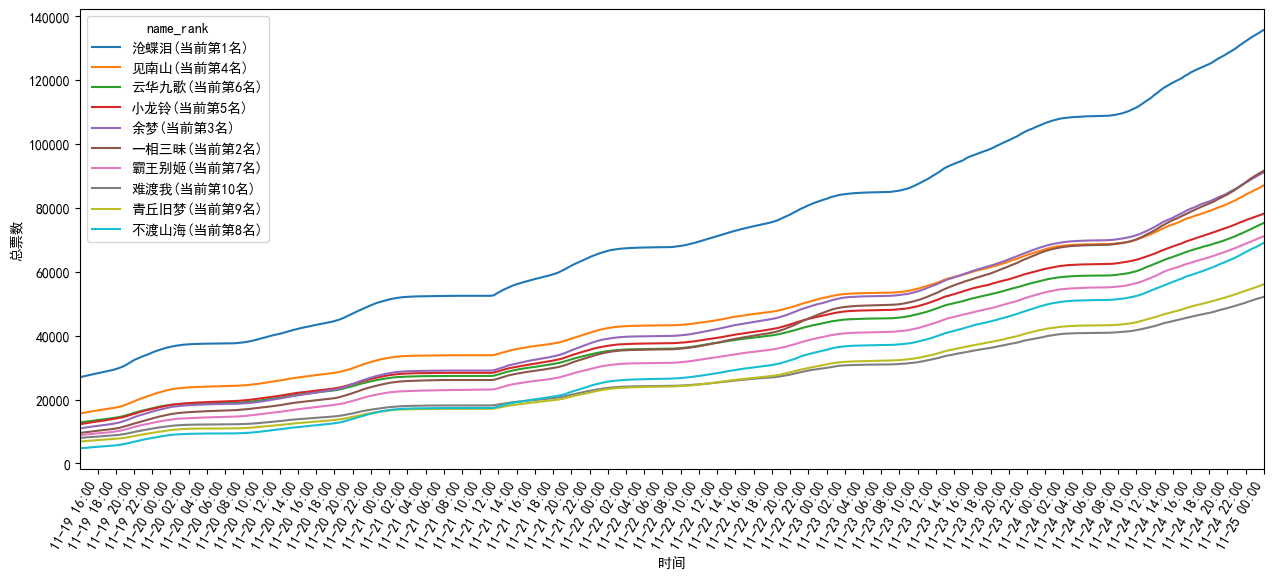

In [180]:
sns.lineplot(data=data_filtered, x='fetch_time', y='total', hue='name_rank')

locator = mdates.HourLocator(interval=2)
plt.gca().xaxis.set_major_locator(locator)

# 设置 x 轴的时间范围
start_time = data_filtered['fetch_time'].min()
end_time = pd.to_datetime('2024-11-25 00:00:00')
plt.xlim(start_time, end_time)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.ylabel('总票数')
plt.xlabel('时间')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
plt.gcf().set_size_inches(14, 6)

plt.show()

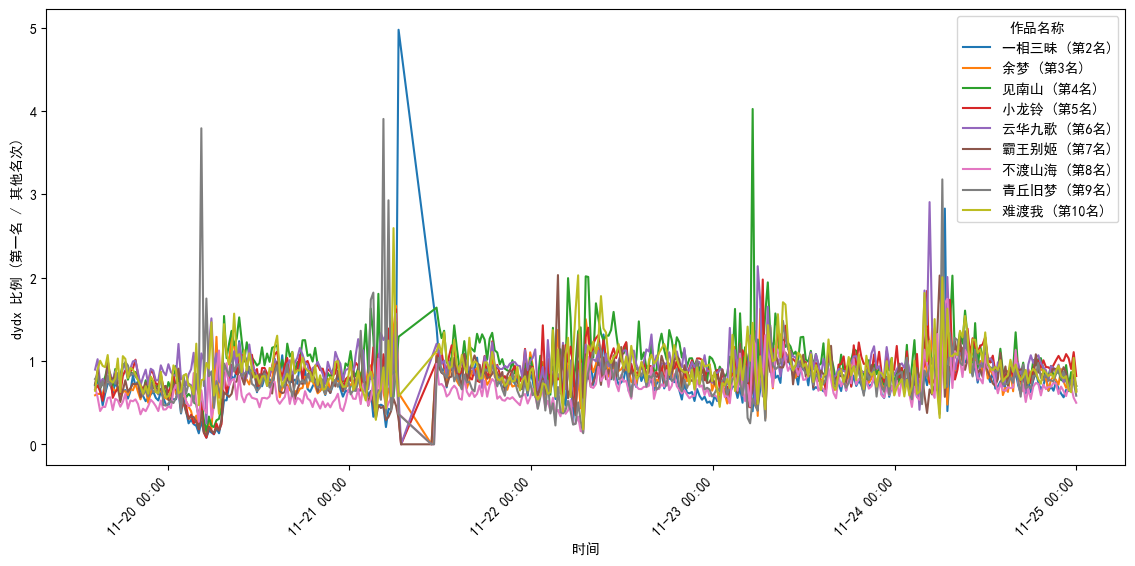

In [172]:
# 获取第一名的数据
first_place = data[data['work_id'] == ids[0]]

# 初始化一个空的 DataFrame 来存储所有的 dydx_ratio
all_ratios = pd.DataFrame()

# 对第二名到第十名运用相同的方法
for i in range(1, 10):
    second_place = data[data['work_id'] == ids[i]]
    
    # 合并两个数据框，按时间点对齐
    merged = pd.merge(first_place[['fetch_time', 'dydx']], second_place[['fetch_time', 'dydx', 'name']], on='fetch_time', suffixes=('_first', f'_{i}'))
    
    # 计算第一名的 dydx 除以第二名对应时间点的 dydx
    merged[f'dydx_ratio_{i}'] = merged['dydx_first'] / merged[f'dydx_{i}']
    
    # 只保留 fetch_time 和 dydx_ratio 列，并添加一个列来标识第二名的 work_name
    merged = merged[['fetch_time', f'dydx_ratio_{i}', 'name']].rename(columns={f'dydx_ratio_{i}': 'dydx_ratio'})
    merged['work_name'] = merged['name'] + f" (第{i+1}名)"
    merged = merged.drop(columns=['name'])
    
    # 将结果添加到 all_ratios DataFrame 中
    all_ratios = pd.concat([all_ratios, merged], ignore_index=True)

# 绘制曲线
sns.lineplot(data=all_ratios, x='fetch_time', y='dydx_ratio', hue='work_name', palette='tab10')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.ylabel('dydx 比例 (第一名 / 其他名次)')
plt.xlabel('时间')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d %H:%M'))
plt.gcf().set_size_inches(12, 6)
plt.legend(title='作品名称')
plt.show()